### Setup

In [1]:
import os
import json
import pandas as pd
import seaborn as sns

import spacy
from tqdm import tqdm
from spacytextblob.spacytextblob import SpacyTextBlob

# setup
cls = lambda: os.system('cls')
os.chdir('C:\\Users\\foolo\\OneDrive\\School\\2022\\compSoc\\Assignments\\data\\yelp')
nlp = spacy.load('en_core_web_md')
nlp.add_pipe('spacytextblob')


# open file and create a df with 10000 lines
with open('yelp.jsonl', 'r', encoding='utf-8') as f:
    r = {}
    for i, line in enumerate(f):
        r[i] = json.loads(line)
    reviews = pd.DataFrame.from_dict(r, orient='index')
    print(reviews, reviews.columns, sep='\n\n')

reviews.text = reviews.text.astype(str)

                   review_id                 user_id             business_id  \
0     KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1     BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2     saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3     AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4     Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
...                      ...                     ...                     ...   
9995  ZcBtCA9jGhLfakf1jJ2BAg  yab1cq5yzrTHzoyz8LYqYQ  1-z7wd860Rii4kbEMCT8DA   
9996  UIkEO-10J6Y99IhRqUflvg  lYAmgL_l7A3MPFYe1DYKrw  EpREWeEpmR8f1qLHzzF0AA   
9997  S-NQM3Axcg8JS3MXHUIvyw  rE2WwfgJbYfvDwBlgq__dQ  dvidzWEPgTQPeBc8CUV2OQ   
9998  ME79YrEhm2xe4IQy_0zkGw  OnIklvzKDpk1BduC84TrTA  2XYPFRm7teCUr3eGsB2-qw   
9999  05oKtleZ-JFGD6qt47VQcg  p0MhNWkwOPBfRo8qUb7faw  rnaE88k8yV5pFAGJeiIK4Q   

      stars  useful  funny  cool  \
0  

### Q14.1

In [2]:
# add three columns for each entry's polarity, subjectivity, and subjective phrases
# subjective phrases are merged into one string to prep for question 2
review_text = reviews.text.str.lower().to_list()
polarity = []
subjectivity = []
lopl = []
for com in tqdm(review_text, ncols=90):
    doc = nlp(com)
    pl = []
    polar = doc._.blob.polarity; polarity.append(polar)
    subj = doc._.blob.subjectivity; subjectivity.append(subj)
    for tuple in doc._.blob.sentiment_assessments.assessments:
        pl.append(' '.join(tuple[0]))
    phrase = ''
    for item in pl:
        phrase += f'{item} '
    lopl.append(phrase)

reviews['pol_value'] = polarity
reviews['subj_value'] = subjectivity
reviews['sent_phrases'] = lopl

100%|███████████████████████████████████████████████| 10000/10000 [03:53<00:00, 42.79it/s]


<AxesSubplot:xlabel='stars', ylabel='pol_value'>

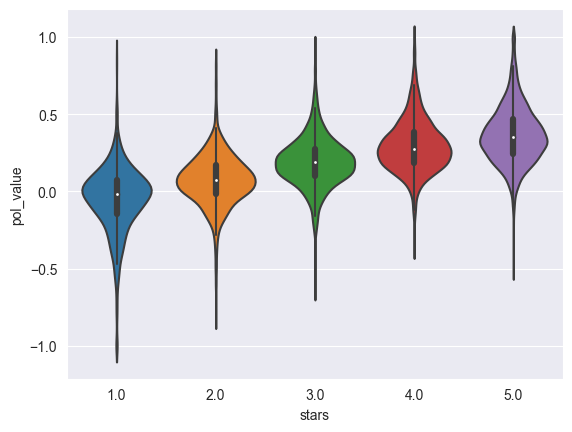

In [3]:
# violin plot
sns.violinplot(x='stars', y='pol_value', data=reviews)

Discussion:
- The polarity score is positively correlated with rating score
- The lowest rating has a slightly 'fatter' tail towards negative polarity, with most in the netral areas, which may indicate that most people tries to keep their wording somewhat neutral
- Fatter tails for ratings 1 and 5 (in opposite direction) indicates that people use more heavy wording for the two extremes

### Q14.2

In [4]:
# function to get similarity based on
# (1) a df,
# (2) the id column where there are multiple id columns
# (3) field to check
# (4) the actual id
# (5) number of top entries to show/return
def get_similarity(df, id_col, chk_col, id, n):
    tally = {}
    p_i = df[id_col].tolist().index(id)
    prime = nlp(df.loc[p_i, chk_col])
    for i in tqdm(range(len(df)), ncols=90):
        target_id = df.loc[i, id_col]
        target = nlp(df.loc[i, chk_col])
        sim = prime.similarity(target)
        tally[target_id] = sim
    s = {k : tally[k] for k in sorted(tally, key=tally.get, reverse=True)}
    top = list(s.keys())[1:n+1]
    print(top)
    return s, top

In [5]:
id_list = ["40thYphUgIfvJq17QCfTwA",
"E9AB7V4z8xrt2uPF7T55FQ",
"4PHFo_GRG4FEk1q4X7xQVQ",
"4KpIldEM-tdnrJLqYzRfZQ",
"PDHRlnEdkEcwATry4w71PQ",
"meGaFP7yxQdjyABrYDVeoQ",
"pgESDcC7eDx4z_epqon4_Q",
"qeSxL-POvGLZD6aQ5O9kvw"]

# the code below run through the id list, each return a list of
# (1) original rating and text
# (2) top three similar text with rating and review_id
# a final table with 8 rows of output
top_three = {}
for id in tqdm(id_list, ncols=90):
    org_rate = reviews.loc[reviews.review_id == id, 'stars'].item()
    org_text = reviews.loc[reviews.review_id == id, 'text'].item()
    top_ids = get_similarity(reviews, 'review_id', 'text', id, 3)[1]
    top_text = [f'rating: {org_rate}\nreview_text: {org_text}']
    for top_id in top_ids:
        rate = reviews.loc[reviews.review_id == top_id, 'stars'].item()
        text = reviews.loc[reviews.review_id == top_id, 'text'].item()
        top_text.append(f'review_id: {top_id}\nrating: {rate}\nreview_text: {text}')
    top_three[id] = top_text

 12%|██████▊                                               | 1/8 [03:48<26:42, 228.98s/it]

['if9f6SBkdeIfLrkvb--2eA', 'PiNvJMzoGUpL1wWOz9_opA', 'QB8nfUIuQoJZnANLOHBynQ']



 25%|█████████████▌                                        | 2/8 [07:36<22:48, 228.08s/it]

['6qJfRQ90bar4R6hPbgqkUA', 'UOfpciAn1koaoGYDTFoW7g', 'T5co7A8L05GzOBdPqvl66w']



 38%|████████████████████▎                                 | 3/8 [11:23<18:58, 227.62s/it]

['lqIkt55Dmte7vZdh068zUg', 'EH6chIRUdBrPQ2DKZgJPkg', 'uZmvUGEuund53xSvYwlR0g']



 50%|███████████████████████████                           | 4/8 [15:54<16:19, 244.94s/it]

['DukuFH25u4ETNsOf8oJ9VA', '1DTGbCY_5JVGtarhBufxPQ', 'hvOuqtjSELmxoI8_xCb6qQ']



 62%|█████████████████████████████████▊                    | 5/8 [20:18<12:35, 251.73s/it]

['QgWZ1JJwSUUtakVoaLD9Gg', 'J85-h1OXgjVCo8YLfrswTQ', 'kUatmtElgnyiohuOD97FgA']



 75%|████████████████████████████████████████▌             | 6/8 [24:39<08:29, 254.85s/it]

['VNV_mm26P182OqCUGNYp5Q', 'glEcAUzdCdK68ed_Dd8ugw', 'yXTLeH_M0BLjQ8PtvKvujA']



 88%|███████████████████████████████████████████████▎      | 7/8 [28:47<04:12, 252.63s/it]

['jw1BDavRDHtbXnYpcFuuJg', '9GXIfrwJn-0sc_cv8lxc5g', 'hz5iX2BQuhsWTnvv__ZudA']



100%|██████████████████████████████████████████████████████| 8/8 [32:47<00:00, 245.90s/it]

['YcLXh-3UC9y6YFAI9xxzPQ', 'AGc3jqyPvLKXDaS6yVKm_g', 'zHqZ1ym04EB_4IXppIX5Eg']


In [6]:
tally_table = pd.DataFrame.from_dict(top_three, orient='index', columns=['origin', 'first', 'second', 'third'])
tally_table.to_csv('tally.csv', index=False)
print(tally_table)

                                                                   origin  \
40thYphUgIfvJq17QCfTwA  rating: 5.0\nreview_text: Great staff always h...   
E9AB7V4z8xrt2uPF7T55FQ  rating: 5.0\nreview_text: Amazing biscuits and...   
4PHFo_GRG4FEk1q4X7xQVQ  rating: 5.0\nreview_text: A GREAT EXPERIENCE!!...   
4KpIldEM-tdnrJLqYzRfZQ  rating: 5.0\nreview_text: I've only had the ca...   
PDHRlnEdkEcwATry4w71PQ  rating: 1.0\nreview_text: If I could give it a...   
meGaFP7yxQdjyABrYDVeoQ  rating: 1.0\nreview_text: Skip this train wrec...   
pgESDcC7eDx4z_epqon4_Q  rating: 1.0\nreview_text: Came for all-you-can...   
qeSxL-POvGLZD6aQ5O9kvw  rating: 1.0\nreview_text: --------DINNER REVIE...   

                                                                    first  \
40thYphUgIfvJq17QCfTwA  review_id: if9f6SBkdeIfLrkvb--2eA\nrating: 5.0...   
E9AB7V4z8xrt2uPF7T55FQ  review_id: 6qJfRQ90bar4R6hPbgqkUA\nrating: 3.0...   
4PHFo_GRG4FEk1q4X7xQVQ  review_id: lqIkt55Dmte7vZdh068zUg\nrating: 4.0...  

Discussion:
- The second and third most identical reviews have better rating score matching with the original; the problem is more concentrated on the imprecision in matching for lower score
- This is actually not very surprising, since our similarity score is being calcualted based on a string of 'subjective phrases' text that contains a lot of adverbs like 'very' to complement the adjectives (negative or positive)
- In conjunction witht the polarity score in Q1, we can hypothesize that people tend to use a lot more adverbs at the two extremes, leading to vector-based similarity score being closer with the addition of all these words